In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Dataset/plantvillage_dataset/color"


 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_virus
 Tomato_

In [ ]:


import os

dataset_path = "/content/drive/MyDrive/Dataset/plantvillage_dataset/color"

allowed_classes = [
    "Tomato___Target_Spot",
    "Pepper,_bell___Bacterial_spot",
    "Grape___Black_rot",
    "Corn_(maize)___Common_rust_",
    "Cherry_(including_sour)___Powdery_mildew"
]  # 5 CLASSES

selected_classes = [c for c in allowed_classes if os.path.isdir(os.path.join(dataset_path, c))]
selected_classes = sorted(selected_classes)

print("Selected Classes:")
for c in selected_classes:
    print(" -", c)
print("Number of classes:", len(selected_classes))

# Where to save models/checkpoints in Drive
save_dir = "/content/drive/MyDrive/Plantvillage_Dataset"
os.makedirs(save_dir, exist_ok=True)

print("\nDataset folder exists:", os.path.isdir(dataset_path))
print("Save dir:", save_dir)

# optional: list dataset folder
!ls "{dataset_path}"


Selected Classes:
 - Cherry_(including_sour)___Powdery_mildew
 - Corn_(maize)___Common_rust_
 - Grape___Black_rot
 - Pepper,_bell___Bacterial_spot
 - Tomato___Target_Spot
Number of classes: 5

Dataset folder exists: True
Save dir: /content/drive/MyDrive/Plantvillage_Dataset
 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___heal

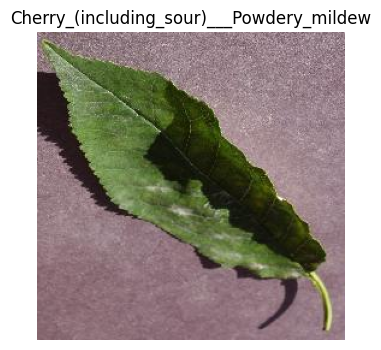

Image path: /content/drive/MyDrive/Dataset/plantvillage_dataset/color/Cherry_(including_sour)___Powdery_mildew/298721d3-169b-46d0-bf19-c54f7c07e0c9___FREC_Pwd.M 5148.JPG


In [ ]:
import random
import cv2
import matplotlib.pyplot as plt

class_name = random.choice(selected_classes)
class_path = os.path.join(dataset_path, class_name)
img_name = random.choice([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
img_path = os.path.join(class_path, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title(class_name)
plt.axis("off")
plt.show()

print("Image path:", img_path)


In [ ]:
import numpy as np
import tensorflow as tf

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

IMG_SIZE = 224      # ResNet50 standard. You can set 256 if you want (slower).
BATCH_SIZE = 32     # Use 16 if you hit memory limits
AUTOTUNE = tf.data.AUTOTUNE

print("TensorFlow:", tf.__version__)
print("IMG_SIZE:", IMG_SIZE, "BATCH_SIZE:", BATCH_SIZE)


TensorFlow: 2.19.0
IMG_SIZE: 224 BATCH_SIZE: 32


In [ ]:
from sklearn.model_selection import train_test_split

# Collect image file paths + labels
image_paths = []
image_labels = []

valid_ext = (".jpg", ".jpeg", ".png", ".bmp")

for label_idx, class_name in enumerate(selected_classes):
    class_dir = os.path.join(dataset_path, class_name)
    files = [f for f in os.listdir(class_dir) if f.lower().endswith(valid_ext)]
    for f in files:
        image_paths.append(os.path.join(class_dir, f))
        image_labels.append(label_idx)

image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

print("Total images found:", len(image_paths))

# 70/15/15 split (stratified = keeps class ratios similar)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, image_labels,
    test_size=0.30,
    random_state=SEED,
    stratify=image_labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.50,
    random_state=SEED,
    stratify=temp_labels
)

print("Train/Val/Test sizes:", len(train_paths), len(val_paths), len(test_paths))


Total images found: 5825
Train/Val/Test sizes: 4077 874 874


In [ ]:
def load_image(path, label):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)  # keep 0..255 for ResNet preprocess
    return img, label

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_paths, train_labels, training=True)
val_ds   = make_ds(val_paths, val_labels, training=False)
test_ds  = make_ds(test_paths, test_labels, training=False)

# Quick check
for x, y in train_ds.take(1):
    print("Batch images:", x.shape, "dtype:", x.dtype)
    print("Batch labels:", y.shape, "example:", y[:10].numpy())


Batch images: (32, 224, 224, 3) dtype: <dtype: 'float32'>
Batch labels: (32,) example: [1 2 4 2 4 0 4 2 1 0]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

num_classes = len(selected_classes)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=train_labels
)

class_weight_dict = {i: float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)


Class weights: {0: 1.1078804347826088, 1: 0.9776978417266187, 2: 0.9871670702179177, 3: 1.1681948424068769, 4: 0.8295015259409969}


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="augmentation")

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
base_model.trainable = False  # BEFORE fine-tuning

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)  # correct preprocessing for ResNet50
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ augmentation[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │     10,245 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Stage 1 checkpoint: /content/drive/MyDrive/Plantvillage_Dataset/best_resnet50_stage1.weights.h5


In [ ]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weight_dict,   # you can remove this if you want
    callbacks=callbacks_stage1
)

# Load best stage-1 weights for a clean "before fine-tuning" evaluation
model.load_weights(stage1_ckpt)

best_val_acc_stage1 = float(np.max(history_1.history["val_accuracy"]))
test_loss_1, test_acc_1 = model.evaluate(test_ds, verbose=0)

print("\n===== BEFORE FINE-TUNING (Stage 1) =====")
print("Best Val Accuracy (Stage 1):", best_val_acc_stage1)
print("Test Accuracy (Stage 1):    ", float(test_acc_1))

# Save the stage-1 model (optional)
stage1_model_path = os.path.join(save_dir, "resnet50_stage1_feature_extraction.keras")
model.save(stage1_model_path)
print("Saved Stage-1 model to:", stage1_model_path)


Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7862 - loss: 0.5939
Epoch 1: val_accuracy improved from -inf to 0.99428, saving model to /content/drive/MyDrive/Plantvillage_Dataset/best_resnet50_stage1.weights.h5
128/128 ━━━━━━━━━━━━━━━━━━━━ 1265s 10s/step - accuracy: 0.7872 - loss: 0.5913 - val_accuracy: 0.9943 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9867 - loss: 0.0540
Epoch 2: val_accuracy improved from 0.99428 to 0.99771, saving model to /content/drive/MyDrive/Plantvillage_Dataset/best_resnet50_stage1.weights.h5
128/128 ━━━━━━━━━━━━━━━━━━━━ 1131s 9s/step - accuracy: 0.9868 - loss: 0.0539 - val_accuracy: 0.9977 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9918 - loss: 0.0328
Epoch 3: val_accuracy improved from 0.99771 to 1.00000, saving model to /content/drive/MyDrive/Plantvillage_Dataset/best_resnet50_stage1.weights.h5
128/128 ━━━━━━━━━

In [ ]:
# Unfreeze backbone for fine-tuning
base_model.trainable = True

# Unfreeze only the last N layers (keeps training stable)
N = 30
for layer in base_model.layers[:-N]:
    layer.trainable = False

# Freeze BatchNorm layers (common best-practice when fine-tuning with small batches)
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# IMPORTANT: lower LR for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks_stage2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=stage2_ckpt,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=callbacks_stage2
)

# Load best stage-2 weights and evaluate
model.load_weights(stage2_ckpt)

best_val_acc_stage2 = float(np.max(history_2.history["val_accuracy"]))
test_loss_2, test_acc_2 = model.evaluate(test_ds, verbose=0)

print("\n===== AFTER FINE-TUNING (Stage 2) =====")
print("Best Val Accuracy (Stage 2):", best_val_acc_stage2)
print("Test Accuracy (Stage 2):    ", float(test_acc_2))


Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9957 - loss: 0.0153 
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/Plantvillage_Dataset/best_resnet50_stage2.weights.h5
128/128 ━━━━━━━━━━━━━━━━━━━━ 1501s 12s/step - accuracy: 0.9957 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 0.0013 - learning_rate: 1.0000e-05
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9984 - loss: 0.0040 
Epoch 2: val_accuracy did not improve from 1.00000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1495s 12s/step - accuracy: 0.9984 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 1.0000e-05
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9988 - loss: 0.0032
Epoch 3: val_accuracy did not improve from 1.00000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1467s 11s/step - accuracy: 0.9988 - loss: 0.0032 - val_accuracy: 0.9989 - val_loss: 0.0021 - learning_rate: 1.0000e-05
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/st

In [ ]:
final_model_path = os.path.join(save_dir, "resnet50_finetuned_final.keras")
model.save(final_model_path)
print("Saved FINAL fine-tuned model to:", final_model_path)


Saved FINAL fine-tuned model to: /content/drive/MyDrive/Plantvillage_Dataset/resnet50_finetuned_final.keras


In [ ]:
import tensorflow as tf
import os

final_model_path = "/content/drive/MyDrive/Plantvillage_Dataset/resnet50_finetuned_final.keras"

model = tf.keras.models.load_model(final_model_path)
print("Model loaded from:", final_model_path)


Model loaded from: /content/drive/MyDrive/Plantvillage_Dataset/resnet50_finetuned_final.keras


Test image path: /content/drive/MyDrive/Dataset/plantvillage_dataset/color/Grape___Black_rot/5ce9d6df-162c-4488-9b80-eadfcbd1d02c___FAM_B.Rot 0563.JPG
True label index: 2
True label name : Grape___Black_rot


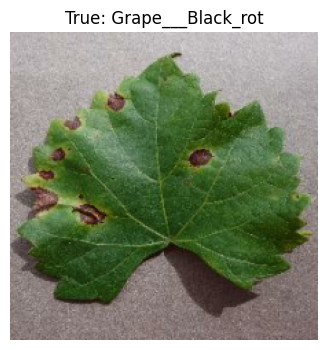

Predicted class: Grape___Black_rot
Confidence     : 100.0 %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Pick a random test image path
idx = random.randint(0, len(test_paths) - 1)
img_path = test_paths[idx]
true_label = test_labels[idx]

print("Test image path:", img_path)
print("True label index:", true_label)
print("True label name :", selected_classes[true_label])

# Load & preprocess image
img = tf.io.read_file(img_path)
img = tf.image.decode_image(img, channels=3, expand_animations=False)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
img = tf.cast(img, tf.float32)

# Show image
plt.figure(figsize=(4,4))
plt.imshow(img.numpy().astype("uint8"))
plt.title(f"True: {selected_classes[true_label]}")
plt.axis("off")
plt.show()

# Predict
img_batch = tf.expand_dims(img, axis=0)
preds = model.predict(img_batch, verbose=0)
pred_class = int(np.argmax(preds))
confidence = float(np.max(preds))

print("Predicted class:", selected_classes[pred_class])
print("Confidence     :", round(confidence * 100, 2), "%")


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Metrics
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro"
)

print("===== FINAL TEST METRICS =====")
print("Accuracy :", round(acc, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1-score :", round(f1, 4))
print("\nDetailed Report:\n")
print(classification_report(y_true, y_pred, target_names=selected_classes))


===== FINAL TEST METRICS =====
Accuracy : 0.9989
Precision: 0.9987
Recall   : 0.9987
F1-score : 0.9987

Detailed Report:

                                          precision    recall  f1-score   support

Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       158
             Corn_(maize)___Common_rust_       1.00      1.00      1.00       179
                       Grape___Black_rot       1.00      1.00      1.00       177
           Pepper,_bell___Bacterial_spot       0.99      1.00      1.00       150
                    Tomato___Target_Spot       1.00      1.00      1.00       210

                                accuracy                           1.00       874
                               macro avg       1.00      1.00      1.00       874
                            weighted avg       1.00      1.00      1.00       874



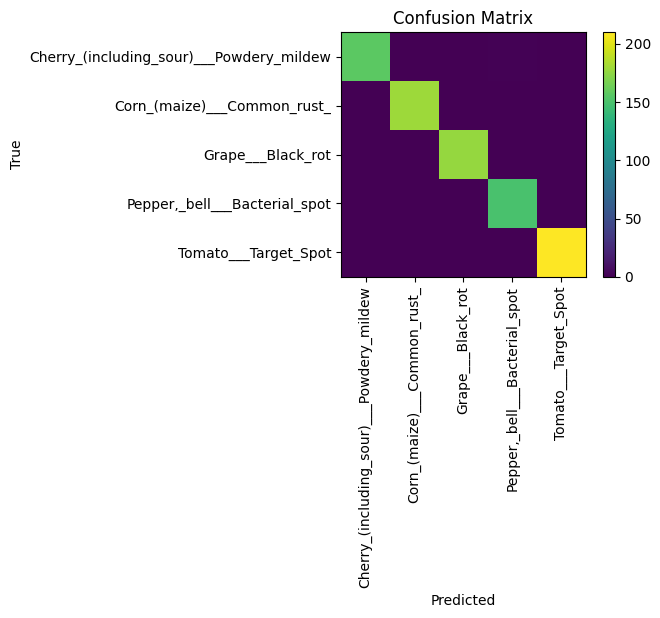

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.colorbar()
plt.xticks(range(len(selected_classes)), selected_classes, rotation=90)
plt.yticks(range(len(selected_classes)), selected_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

LAST_CONV_LAYER = "conv5_block3_out"  # correct for ResNet50

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()


In [ ]:
resnet_backbone = model.get_layer("resnet50")
print("Correct backbone:", resnet_backbone.name)


Correct backbone: resnet50


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    import tensorflow as tf
    import numpy as np

    # 1. Get ResNet backbone
    resnet_backbone = model.get_layer("resnet50")

    # 2. Last conv layer
    last_conv_layer = resnet_backbone.get_layer(last_conv_layer_name)

    # 3. Build Grad-CAM model using BACKBONE INPUT
    grad_model = tf.keras.models.Model(
        inputs=resnet_backbone.input,
        outputs=[last_conv_layer.output, resnet_backbone.output]
    )

    # 4. Forward pass through backbone
    with tf.GradientTape() as tape:
        conv_outputs, backbone_outputs = grad_model(img_array)
        pooled = tf.reduce_mean(backbone_outputs, axis=(1, 2))
        pred_index = tf.argmax(pooled[0])
        loss = pooled[:, pred_index]

    # 5. Gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 6. Generate heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()


In [ ]:
def show_gradcam(img, heatmap, alpha=0.4):
    import matplotlib.pyplot as plt
    import tensorflow as tf
    import numpy as np

    heatmap = tf.image.resize(
        heatmap[..., np.newaxis],
        (img.shape[0], img.shape[1])
    ).numpy().squeeze()

    heatmap = np.uint8(255 * heatmap)

    plt.figure(figsize=(5,5))
    plt.imshow(img.astype("uint8"))
    plt.imshow(heatmap, cmap="jet", alpha=alpha)
    plt.axis("off")
    plt.title("Grad-CAM Explanation")
    plt.show()


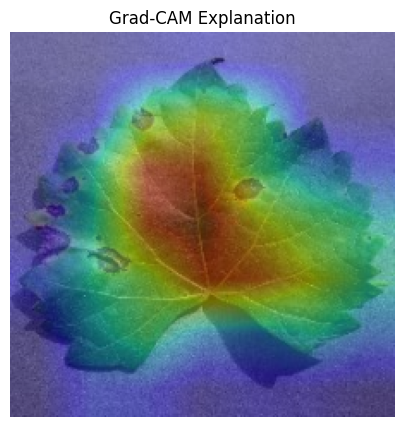

In [ ]:
# Preprocess manually (same as training)
img_for_gradcam = tf.keras.applications.resnet50.preprocess_input(
    tf.cast(img_batch, tf.float32)
)

LAST_CONV_LAYER = "conv5_block3_out"

heatmap = make_gradcam_heatmap(img_for_gradcam, model, LAST_CONV_LAYER)
show_gradcam(img.numpy(), heatmap)


In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="resnet50_full_model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,   # IMPORTANT: shows ResNet50 internals
    dpi=200
)


In [ ]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ augmentation[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │     10,245 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,475,793 (200.18 MB)

 Trainable params: 14,438,917 (55.08 MB)

 Non-trainable params: 9,159,040 (34.94 MB)

 Optimizer params: 28,877,836 (110.16 MB)

In [ ]:
import tensorflow as tf

# Important layers we want to visualize
layer_names = [
    "augmentation",
    "resnet50",
    "global_average_pooling2d",
    "dropout",
    "dense"
]

outputs = [model.get_layer(name).output for name in layer_names]

step_model = tf.keras.Model(
    inputs=model.input,
    outputs=outputs
)


In [ ]:
# Augmentation model only
augmentation_layer = model.get_layer("augmentation")

aug_model = tf.keras.Model(
    inputs=model.input,
    outputs=augmentation_layer.output
)

aug_out = aug_model(img_batch)
print("Augmentation output shape:", aug_out.shape)


Augmentation output shape: (1, 224, 224, 3)


In [ ]:
# Preprocess manually (same as training)
img_preprocessed = tf.keras.applications.resnet50.preprocess_input(
    tf.cast(img_batch, tf.float32)
)

resnet_backbone = model.get_layer("resnet50")

resnet_model = tf.keras.Model(
    inputs=resnet_backbone.input,
    outputs=resnet_backbone.output
)

resnet_out = resnet_model(img_preprocessed)
print("ResNet50 output shape:", resnet_out.shape)


ResNet50 output shape: (1, 7, 7, 2048)


In [ ]:
# Get head layers
gap_layer = model.get_layer("global_average_pooling2d")
dropout_layer = model.get_layer("dropout")
dense_layer = model.get_layer("dense")

# Forward step-by-step
gap_out = gap_layer(resnet_out)
drop_out = dropout_layer(gap_out, training=False)
pred_out = dense_layer(drop_out)

print("GAP output shape:", gap_out.shape)
print("Dropout output shape:", drop_out.shape)
print("Final prediction shape:", pred_out.shape)


GAP output shape: (1, 2048)
Dropout output shape: (1, 2048)
Final prediction shape: (1, 5)


In [ ]:
import pandas as pd

data = [
    ("Augmentation", aug_out.shape),
    ("ResNet50 Backbone", resnet_out.shape),
    ("Global Average Pooling", gap_out.shape),
    ("Dropout", drop_out.shape),
    ("Dense (Softmax)", pred_out.shape),
]

df = pd.DataFrame(data, columns=["Stage", "Output Shape"])
df


,Stage,Output Shape
0,Augmentation,"(1, 224, 224, 3)"
1,ResNet50 Backbone,"(1, 7, 7, 2048)"
2,Global Average Pooling,"(1, 2048)"
3,Dropout,"(1, 2048)"
4,Dense (Softmax),"(1, 5)"


In [ ]:
import os

TFLITE_DIR = "/content/drive/MyDrive/Plantvillage_Project/tflite_models"
os.makedirs(TFLITE_DIR, exist_ok=True)

KERAS_MODEL_PATH = "/content/drive/MyDrive/Plantvillage_Project/saved_models/resnet50_finetuned_final.keras"


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(KERAS_MODEL_PATH)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ augmentation[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │     10,245 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,475,793 (200.18 MB)

 Trainable params: 14,438,917 (55.08 MB)

 Non-trainable params: 9,159,040 (34.94 MB)

 Optimizer params: 28,877,836 (110.16 MB)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_fp32_path = os.path.join(TFLITE_DIR, "resnet50_fp32.tflite")

with open(tflite_fp32_path, "wb") as f:
    f.write(tflite_model)

print("Saved FP32 TFLite model:", tflite_fp32_path)


Saved artifact at '/tmp/tmpfxv3tzgh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132540740070160: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132540820910160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820878160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820913232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540821040464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820900752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540821033360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820904976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820998096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820871056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1325

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_dynamic = converter.convert()

tflite_dynamic_path = os.path.join(TFLITE_DIR, "resnet50_dynamic.tflite")

with open(tflite_dynamic_path, "wb") as f:
    f.write(tflite_dynamic)

print("Saved Dynamic Quantized TFLite model:", tflite_dynamic_path)


Saved artifact at '/tmp/tmp7x57r5t2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132540740070160: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132540820910160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820878160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820913232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540821040464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820900752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540821033360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820904976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820998096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132540820871056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1325

In [ ]:
def file_size_mb(path):
    return os.path.getsize(path) / (1024 * 1024)

print("Keras model size:", file_size_mb(KERAS_MODEL_PATH), "MB")
print("FP32 TFLite size:", file_size_mb(tflite_fp32_path), "MB")
print("Dynamic TFLite size:", file_size_mb(tflite_dynamic_path), "MB")


Keras model size: 200.82874202728271 MB
FP32 TFLite size: 89.65260314941406 MB
Dynamic TFLite size: 22.82341766357422 MB
